In [1]:
%matplotlib inline


# The Johnson-Lindenstrauss bound for embedding with random projections



The `Johnson-Lindenstrauss lemma`_ states that any high dimensional
dataset can be randomly projected into a lower dimensional Euclidean
space while controlling the distortion in the pairwise distances.



In [2]:
print(__doc__)

import sys
from time import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.random_projection import SparseRandomProjection
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.datasets import load_digits
from sklearn.metrics.pairwise import euclidean_distances

# `normed` is being deprecated in favor of `density` in histograms
if LooseVersion(matplotlib.__version__) >= '2.1':
    density_param = {'density': True}
else:
    density_param = {'normed': True}

Automatically created module for IPython interactive environment


Theoretical bounds
==================
The distortion introduced by a random projection `p` is asserted by
the fact that `p` is defining an eps-embedding with good probability
as defined by:

\begin{align}(1 - eps) \|u - v\|^2 < \|p(u) - p(v)\|^2 < (1 + eps) \|u - v\|^2\end{align}

Where u and v are any rows taken from a dataset of shape [n_samples,
n_features] and p is a projection by a random Gaussian N(0, 1) matrix
with shape [n_components, n_features] (or a sparse Achlioptas matrix).

The minimum number of components to guarantees the eps-embedding is
given by:

\begin{align}n\_components >= 4 log(n\_samples) / (eps^2 / 2 - eps^3 / 3)\end{align}


The first plot shows that with an increasing number of samples ``n_samples``,
the minimal number of dimensions ``n_components`` increased logarithmically
in order to guarantee an ``eps``-embedding.



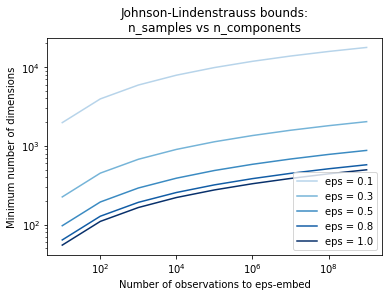

In [3]:
# range of admissible distortions
eps_range = np.linspace(0.1, 0.99, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(eps_range)))

# range of number of samples (observation) to embed
n_samples_range = np.logspace(1, 9, 9)

plt.figure()
for eps, color in zip(eps_range, colors):
    min_n_components = johnson_lindenstrauss_min_dim(n_samples_range, eps=eps)
    plt.loglog(n_samples_range, min_n_components, color=color)

plt.legend(["eps = %0.1f" % eps for eps in eps_range], loc="lower right")
plt.xlabel("Number of observations to eps-embed")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_samples vs n_components")
plt.show()

The second plot shows that an increase of the admissible
distortion ``eps`` allows to reduce drastically the minimal number of
dimensions ``n_components`` for a given number of samples ``n_samples``



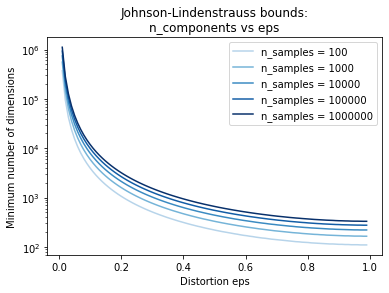

In [4]:
# range of admissible distortions
eps_range = np.linspace(0.01, 0.99, 100)

# range of number of samples (observation) to embed
n_samples_range = np.logspace(2, 6, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(n_samples_range)))

plt.figure()
for n_samples, color in zip(n_samples_range, colors):
    min_n_components = johnson_lindenstrauss_min_dim(n_samples, eps=eps_range)
    plt.semilogy(eps_range, min_n_components, color=color)

plt.legend(["n_samples = %d" % n for n in n_samples_range], loc="upper right")
plt.xlabel("Distortion eps")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_components vs eps")
plt.show()

Empirical validation
====================

We validate the above bounds on the 20 newsgroups text document
(TF-IDF word frequencies) dataset or on the digits dataset:

- for the 20 newsgroups dataset some 500 documents with 100k
  features in total are projected using a sparse random matrix to smaller
  euclidean spaces with various values for the target number of dimensions
  ``n_components``.

- for the digits dataset, some 8x8 gray level pixels data for 500
  handwritten digits pictures are randomly projected to spaces for various
  larger number of dimensions ``n_components``.

The default dataset is the 20 newsgroups dataset. To run the example on the
digits dataset, pass the ``--use-digits-dataset`` command line argument to
this script.



In [5]:
if '--use-digits-dataset' in sys.argv:
    data = load_digits().data[:500]
else:
    data = fetch_20newsgroups_vectorized().data[:500]

For each value of ``n_components``, we plot:

- 2D distribution of sample pairs with pairwise distances in original
  and projected spaces as x and y axis respectively.

- 1D histogram of the ratio of those distances (projected / original).



Embedding 500 samples with dim 130107 using various random projections
Projected 500 samples from 130107 to 300 in 0.739s
Random matrix with size: 1.301MB
Mean distances rate: 0.93 (0.18)
Projected 500 samples from 130107 to 1000 in 3.574s
Random matrix with size: 4.332MB
Mean distances rate: 1.01 (0.10)
Projected 500 samples from 130107 to 10000 in 33.387s
Random matrix with size: 43.311MB
Mean distances rate: 0.99 (0.03)


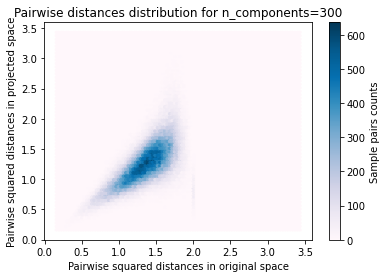

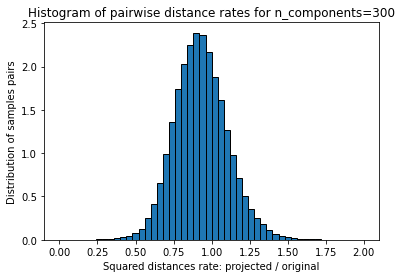

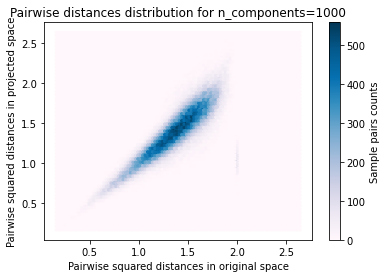

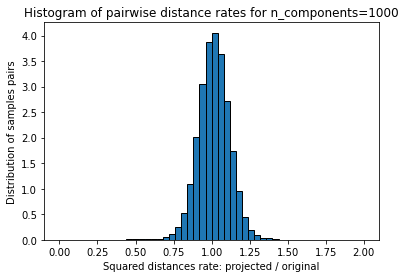

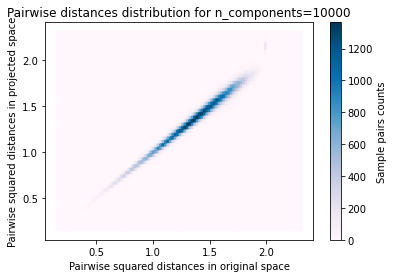

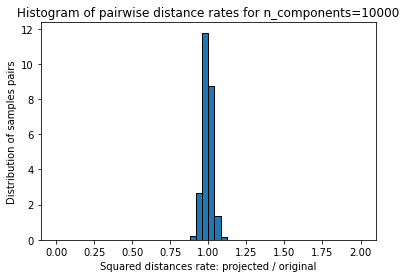

In [6]:
n_samples, n_features = data.shape
print("Embedding %d samples with dim %d using various random projections"
      % (n_samples, n_features))

n_components_range = np.array([300, 1000, 10000])
dists = euclidean_distances(data, squared=True).ravel()

# select only non-identical samples pairs
nonzero = dists != 0
dists = dists[nonzero]

for n_components in n_components_range:
    t0 = time()
    rp = SparseRandomProjection(n_components=n_components)
    projected_data = rp.fit_transform(data)
    print("Projected %d samples from %d to %d in %0.3fs"
          % (n_samples, n_features, n_components, time() - t0))
    if hasattr(rp, 'components_'):
        n_bytes = rp.components_.data.nbytes
        n_bytes += rp.components_.indices.nbytes
        print("Random matrix with size: %0.3fMB" % (n_bytes / 1e6))

    projected_dists = euclidean_distances(
        projected_data, squared=True).ravel()[nonzero]

    plt.figure()
    min_dist = min(projected_dists.min(), dists.min())
    max_dist = max(projected_dists.max(), dists.max())
    plt.hexbin(dists, projected_dists, gridsize=100, cmap=plt.cm.PuBu,
               extent=[min_dist, max_dist, min_dist, max_dist])
    plt.xlabel("Pairwise squared distances in original space")
    plt.ylabel("Pairwise squared distances in projected space")
    plt.title("Pairwise distances distribution for n_components=%d" %
              n_components)
    cb = plt.colorbar()
    cb.set_label('Sample pairs counts')

    rates = projected_dists / dists
    print("Mean distances rate: %0.2f (%0.2f)"
          % (np.mean(rates), np.std(rates)))

    plt.figure()
    plt.hist(rates, bins=50, range=(0., 2.), edgecolor='k', **density_param)
    plt.xlabel("Squared distances rate: projected / original")
    plt.ylabel("Distribution of samples pairs")
    plt.title("Histogram of pairwise distance rates for n_components=%d" %
              n_components)

    # TODO: compute the expected value of eps and add them to the previous plot
    # as vertical lines / region

plt.show()

We can see that for low values of ``n_components`` the distribution is wide
with many distorted pairs and a skewed distribution (due to the hard
limit of zero ratio on the left as distances are always positives)
while for larger values of n_components the distortion is controlled
and the distances are well preserved by the random projection.



Remarks
=======

According to the JL lemma, projecting 500 samples without too much distortion
will require at least several thousands dimensions, irrespective of the
number of features of the original dataset.

Hence using random projections on the digits dataset which only has 64
features in the input space does not make sense: it does not allow
for dimensionality reduction in this case.

On the twenty newsgroups on the other hand the dimensionality can be
decreased from 56436 down to 10000 while reasonably preserving
pairwise distances.

